### mount

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/JnQ/'

os.chdir(current_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### requirements

In [6]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from funcs_indicator import *
# import matplotlib.pyplot as plt

# import mpl_finance as mf
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### load data

In [ ]:
os.chdir(current_path)


interval = '30m'
interval = '5m'
interval = '1m'

date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
# date_path = './candlestick_concated/%s/2021-06-14/' % interval
date_path = './candlestick_concated/%s/eth_set/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-05-17 ETHUSDT.xlsx', '2021-04-17 ETHUSDT.xlsx', '2021-03-18 ETHUSDT.xlsx', '2021-02-16 ETHUSDT.xlsx', '2021-01-17 ETHUSDT.xlsx', '2020-12-18 ETHUSDT.xlsx', '2020-11-18 ETHUSDT.xlsx', '2020-10-19 ETHUSDT.xlsx', '2020-09-19 ETHUSDT.xlsx', '2020-08-20 ETHUSDT.xlsx', '2020-07-21 ETHUSDT.xlsx', '2020-06-21 ETHUSDT.xlsx', '2020-05-22 ETHUSDT.xlsx', '2020-04-22 ETHUSDT.xlsx']


## load res_df_dict

In [7]:
save_path = './candlestick_concated/res_df/'
# dict_name = "2021-06-30 BTCUSDT_4h1d_backi2_res_dfs.pkl"
dict_name = "2021-07-01 ETHUSDT_backi2_res_dfs.pkl"


#     load with pickle    #
with open(save_path + dict_name, 'rb') as f:
  res_df_dict = pickle.load(f)

### windowing + retrain

#### window settings

In [9]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

window_size = 30
input_size = 15
label_size = 15

target = "pr"

start_stamp : 0


#### make datasets

In [12]:
data_x, data_labels = [], []
data_x_labels = []

fee = 0.0006

# close_x, label_close_x = [], []
# data_index = []

basic_list = ['open', 'high', 'low', 'close', 'minor_ST1_Up', 'minor_ST1_Down',
       'minor_ST2_Up', 'minor_ST2_Down', 'minor_ST3_Up', 'minor_ST3_Down',
       'middle_line', 'min_upper', 'max_lower']

senkoua_list = ['senkou_a1', 'senkou_a2', 'senkou_a3', 'senkou_a4', 'senkou_a5']
senkoub_list = ['senkou_b1', 'senkou_b2', 'senkou_b3', 'senkou_b4', 'senkou_b5']

sar_list = ['sar1', 'sar2', 'sar3', 'sar4', 'sar5']
sar_list = ['sar1', 'sar2', 'sar3', 'sar4', 'sar5']

macd_list = ['macd_hist1', 'macd_hist2', 'macd_hist3', 'macd_hist4', 'macd_hist5']

price_colname = basic_list + senkoua_list + senkoub_list + sar_list


for key, res_df in res_df_dict.items():

  df = res_df

  # df['pr'] = df['close'].pct_change()

  #   진입 구간과 이탈 구간에서 발생하는 pr 만들기    #

  # df['pr'] = df['close'].shift(-(label_size - 1)) / df['close']

  #         post fee adjustment       #
  # df['pr'] = df['close'].shift(-(label_size - 1)) / df['close'] - fee
  df['pr'] = df['close'].shift(-label_size) / df['close'] - fee

  # print(df['close'].head(20))
  # print(df['close'].shift(-14).head(20))
  # break

  # sar = lucid_sar(ohlcv)
  # ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
  # ema1, ema2, ema3 = ema_ribbon(ohlcv)
  # senkou1, senkou2 = ichimoku(ohlcv)
  # cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

  # _, _, bbw = bb_width(ohlcv, 20, 2) 

  # print(df.describe().transpose())
  # print(df.head())

  # print((np.isnan(df.values)))
  print("np.sum(np.isnan(df.values), axis=0) :", np.sum(np.isnan(df.values), axis=0))

  max_nan = np.max(np.sum(np.isnan(df.values), axis=0))
  # print(max_nan)

  df = df.iloc[max_nan:-max_nan]

  print("df.describe().transpose() :", df.describe().transpose())


  column_indices = {name: i for i, name in enumerate(df.columns)}
  num_features = df.shape[1]
  print("num_features :", num_features)
  print("column_indices :", column_indices)

  # break
  
  target_label_index = column_indices[target]

  from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
  min_max = MinMaxScaler()
  std_scale = StandardScaler()


  def min_max_scale(npy_x):

    return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


  #       local scaling     #
  # shift_size = window_size
  shift_size = label_size
  # shift_size = 1

  #       Todo      #
  #       1. use global scaling for outer price data      #
  gscale_data = min_max_scale(df[macd_list].values)

  for i in tqdm(range(input_size, len(df), shift_size)):
      
      # temp_data = df.values[i - input_size:i]
      # temp_labels = df.values[i:i + label_size]

      # scaled_data = min_max_scale(df.values[i - input_size:i + label_size])
      # scaled_data = min_max.fit_transform(df.values[i - input_size:i + label_size])
      # temp_data = scaled_data[:input_size]
      # temp_labels = scaled_data[input_size:]

      #     on price data    #
      lscale_data = min_max_scale(df[price_colname].values[i - input_size:i])
      
      prev_data = df[price_colname].values[i - input_size:i]
      label_data = df[price_colname].values[i: i + label_size]
      temp_x_labels = (label_data - np.min(prev_data)) / (np.max(prev_data) - np.min(prev_data))

      temp_labels = df.values[i, target_label_index]

      temp_data = np.hstack((lscale_data, gscale_data[i - input_size:i]))



      # temp_data = std_scale.fit_transform(df.values[i - input_size:i])
      # # temp_labels = std_scale.transform(df.values[i:i + label_size])
      # temp_labels = df.values[i + shift - input_size:i + shift]

      # print(df.index[i - input_size:i][-1])
      # print(df.index[i:i + label_size][0])
      # print()

      if np.isnan(np.sum(temp_data)) or np.isnan(np.sum(temp_x_labels)):
        continue

      if len(temp_x_labels) < label_size:
        continue

      data_x.append(temp_data)
      data_x_labels.append(temp_x_labels)
      data_labels.append(temp_labels)
      # close_x.append(df.values[i - input_size:i, [3]])
      # label_close_x.append(df.values[i:i + label_size, [3]])


  data_x = np.array(data_x).astype(np.float32)
  data_x_labels = np.array(data_x_labels).astype(np.float32)
  data_labels = np.array(data_labels).astype(np.float32)

  # print(len(df) - total_window_size)
  print("data_x.shape :", data_x.shape)
  print("data_x_labels.shape :", data_x_labels.shape)
  print("data_labels.shape :", data_labels.shape)

  print("data_x.dtype :", data_x.dtype)
  print("data_labels.dtype :", data_labels.dtype)

  break # one pair test

np.sum(np.isnan(df.values), axis=0) : [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  50  76  25  25  25  25  25  25  25 145  24   0   0   0   0   0
   0  15]
df.describe().transpose() :                     count         mean          std         min         25%          50%          75%            max
open             431710.0  1432.823341   956.944367  310.750000  475.450000  1398.690000  2108.120000    4368.450000
high             431710.0  1434.538888   958.279636  314.560000  475.750000  1400.850000  2110.060000    4379.180000
low              431710.0  1431.128228   955.649398  307.360000  475.142500  1396.400000  2106.000000    4362.260000
close            431710.0  1432.827477   956.943702  310.580000  475.460000  1398.735000  2108.137500    4368.420000
volume           431710.0  2364.780844  3158.220294    0.000000  766.151250  1453.773500  2762.336500  146387.344000
minor_ST1_Up     431710.0  1441.634024   963.794070  319.955929  477.191153 


data_x.shape : (28779, 15, 33)
data_x_labels.shape : (28779, 15, 28)
data_labels.shape : (28779,)
data_x.dtype : float32
data_labels.dtype : float32


#### save dataset

In [13]:
pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_prefee_varfeat_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_prefee_varfeat_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_prefee_varfeat_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

np.save(x_save_path, data_x)
np.save(x_label_save_path, data_x_labels)
np.save(label_save_path, data_labels)

print("npy saved !")


npy saved !


#### load dataset

In [ ]:
key = "dates ETHUSDT.xlsx"
len_data_x = 20104

shift_size = 30

pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)

data_x = np.load(x_save_path)
data_x_labels = np.load(x_label_save_path)
data_labels = np.load(label_save_path)

print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

data_x.shape : (20104, 15, 10)
data_x_labels.shape : (20104, 15, 10)
data_labels.shape : (20104,)


### single step models

In [14]:
MAX_EPOCHS = 100
# MAX_EPOCHS = 1000
# MAX_EPOCHS = 500

patience = MAX_EPOCHS // 5
# patience = 2

ckpt_path = current_path + 'ckpt/'

def compile_and_fit(model, model_name, train_flow, val_flow, class_weight=None, patience=patience):

  tf.keras.backend.clear_session()

  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

  # model.compile(loss='categorical_crossentropy', 
  #               optimizer=tf.optimizers.Adam(learning_rate=1e-5, decay=5e-6), 
  #               # optimizer=tf.optimizers.Adam(learning_rate=1e-6, decay=5e-7), 
  #               metrics=['accuracy'])
  
  # model.compile(loss='categorical_crossentropy', 
  # model.compile(loss=tf.losses.SparseCategoricalCrossentropy(), 
  #               optimizer=tf.optimizers.Adam(learning_rate=1e-3, decay=1e-4),
  #               metrics=[tf.metrics.Accuracy()])

  model.compile(loss=tf.losses.MeanSquaredError(),
                # optimizer=tf.optimizers.Adam(learning_rate=1e-4, decay=1e-5),
                optimizer=tf.optimizers.Adam(learning_rate=1e-5, decay=5e-6), 
                # optimizer=tf.optimizers.Adam(learning_rate=1e-3, decay=1e-4),
                metrics=[tf.metrics.MeanAbsoluteError()])
  

  history = model.fit(train_flow, epochs=MAX_EPOCHS,
                      validation_data=val_flow,
                      callbacks=[checkpoint, early_stopping],
                      # callbacks=[early_stopping],
                      # class_weight=class_weight
                      )
  return history

#### models

#### cnn 2d

In [15]:
# cnn2d_model = tf.keras.Sequential([
                                 
#       # Shape => [batch, 1, conv_units]
#       # tf.keras.layers.Input(shape=)
#       tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3),
      
#       tf.keras.layers.Flatten(),
#       tf.keras.layers.Dense(128, activation='relu'),
#       tf.keras.layers.Dense(64, activation='relu'),

#       tf.keras.layers.Dense(2, activation="softmax")
# ])


def cnn2d_model(input_shape):

    visible = tf.keras.layers.Input(shape=input_shape, name='input')
    
    net = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.BatchNormalization()(net)
    # net = tf.keras.layers.Activation('relu')(net)
    net = tf.keras.layers.LeakyReLU()(net)
    # net = tf.keras.layers.MaxPool2D(pool_size=2)(net)
    # net = tf.keras.layers.AveragePooling2D(padding='same')(net)


    # net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.BatchNormalization()(net)
    # net = tf.keras.layers.Activation('relu')(net)
    net = tf.keras.layers.LeakyReLU()(net)
    # net = tf.keras.layers.MaxPool2D(pool_size=2)(net)

    net = tf.keras.layers.Flatten()(net)
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Dense(64)(net)
    net = tf.keras.layers.LeakyReLU()(net)

    # net = tf.keras.layers.Dense(2, activation='softmax')(net)
    net = tf.keras.layers.Dense(1)(net)

    # create model 
    model = tf.keras.models.Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

##### lstm

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(1)
])


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.3),
    # Shape => [batch, time, features]
    
    tf.keras.layers.Dense(units=1)
])


##### cnn

In [ ]:
CONV_WIDTH = 3

cnn_model = tf.keras.Sequential([
                                 
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
      # tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(3)),

      tf.keras.layers.Dense(64, activation='relu'),

      tf.keras.layers.Dense(1)
])

#### test_bed

last_index : 10000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 17s 31ms/step - loss: 0.0602 - mean_absolute_error: 0.1528 - val_loss: 0.0029 - val_mean_absolute_error: 0.0412

Epoch 00001: val_loss improved from inf to 0.00285, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_10000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0018 - mean_absolute_error: 0.0319 - val_loss: 8.9597e-04 - val_mean_absolute_error: 0.0239

Epoch 00002: val_loss improved from 0.00285 to 0.00090, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_10000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 5.5922e-04 - mean_absolute_error: 0.0183 - val_loss: 4.5557e-04 - val_

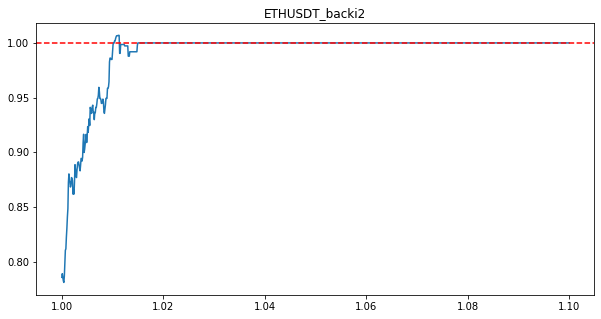

last_index : 11000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 26ms/step - loss: 0.5995 - mean_absolute_error: 0.4503 - val_loss: 0.0095 - val_mean_absolute_error: 0.0772

Epoch 00001: val_loss improved from inf to 0.00946, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_11000.h5
Epoch 2/100
55/55 [==============================] - 1s 23ms/step - loss: 0.0059 - mean_absolute_error: 0.0600 - val_loss: 0.0029 - val_mean_absolute_error: 0.0410

Epoch 00002: val_loss improved from 0.00946 to 0.00288, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_11000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0024 - mean_absolute_error: 0.0380 - val_loss: 0.0015 - val_mean_absolute

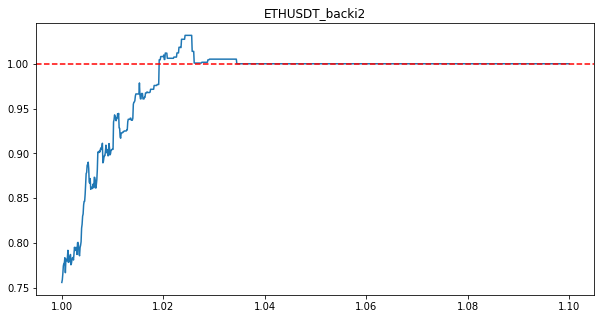

last_index : 12000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 26ms/step - loss: 0.3210 - mean_absolute_error: 0.3222 - val_loss: 0.0096 - val_mean_absolute_error: 0.0815

Epoch 00001: val_loss improved from inf to 0.00965, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_12000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0034 - mean_absolute_error: 0.0457 - val_loss: 0.0020 - val_mean_absolute_error: 0.0348

Epoch 00002: val_loss improved from 0.00965 to 0.00198, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_12000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0014 - mean_absolute_error: 0.0296 - val_loss: 0.0012 - val_mean_absolute

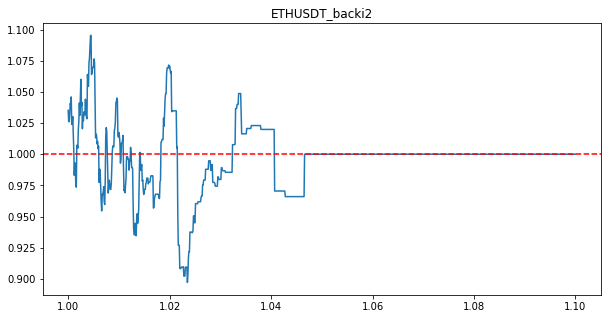

last_index : 13000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.1811 - mean_absolute_error: 0.2597 - val_loss: 0.0064 - val_mean_absolute_error: 0.0622

Epoch 00001: val_loss improved from inf to 0.00644, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_13000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0046 - mean_absolute_error: 0.0516 - val_loss: 0.0021 - val_mean_absolute_error: 0.0356

Epoch 00002: val_loss improved from 0.00644 to 0.00211, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_13000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0015 - mean_absolute_error: 0.0302 - val_loss: 0.0011 - val_mean_absolute

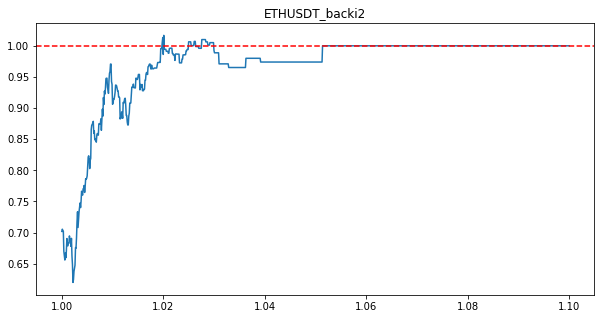

last_index : 14000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 26ms/step - loss: 0.1533 - mean_absolute_error: 0.2147 - val_loss: 0.0045 - val_mean_absolute_error: 0.0515

Epoch 00001: val_loss improved from inf to 0.00446, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_14000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0029 - mean_absolute_error: 0.0413 - val_loss: 0.0015 - val_mean_absolute_error: 0.0308

Epoch 00002: val_loss improved from 0.00446 to 0.00149, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_14000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0011 - mean_absolute_error: 0.0265 - val_loss: 0.0011 - val_mean_absolute

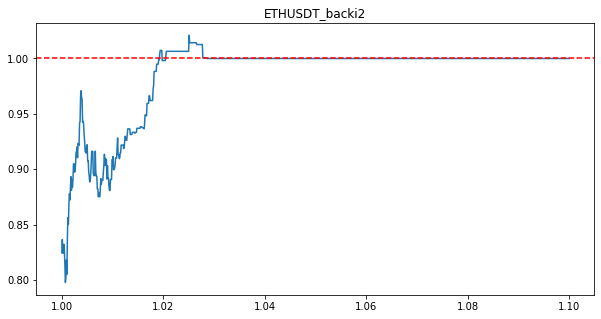

last_index : 15000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 26ms/step - loss: 0.1581 - mean_absolute_error: 0.2344 - val_loss: 0.0070 - val_mean_absolute_error: 0.0684

Epoch 00001: val_loss improved from inf to 0.00704, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_15000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0035 - mean_absolute_error: 0.0464 - val_loss: 0.0023 - val_mean_absolute_error: 0.0373

Epoch 00002: val_loss improved from 0.00704 to 0.00229, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_15000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0015 - mean_absolute_error: 0.0305 - val_loss: 0.0011 - val_mean_absolute

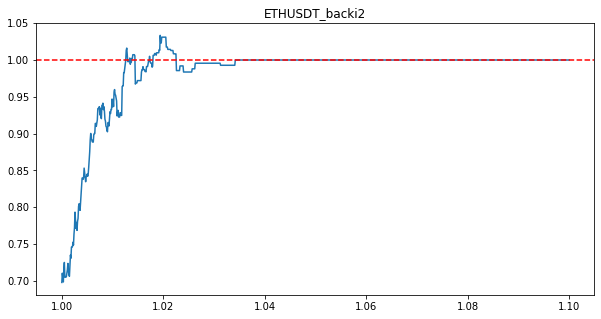

last_index : 16000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 26ms/step - loss: 0.2168 - mean_absolute_error: 0.2777 - val_loss: 0.0077 - val_mean_absolute_error: 0.0689

Epoch 00001: val_loss improved from inf to 0.00775, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_16000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0048 - mean_absolute_error: 0.0534 - val_loss: 0.0028 - val_mean_absolute_error: 0.0412

Epoch 00002: val_loss improved from 0.00775 to 0.00277, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_16000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 0.0014 - val_mean_absolute

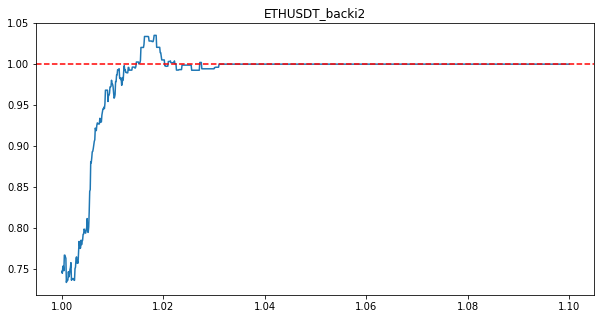

last_index : 17000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 29ms/step - loss: 0.1983 - mean_absolute_error: 0.2653 - val_loss: 0.0055 - val_mean_absolute_error: 0.0596

Epoch 00001: val_loss improved from inf to 0.00547, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_17000.h5
Epoch 2/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0016 - val_mean_absolute_error: 0.0320

Epoch 00002: val_loss improved from 0.00547 to 0.00162, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_17000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0012 - mean_absolute_error: 0.0271 - val_loss: 9.0184e-04 - val_mean_abso

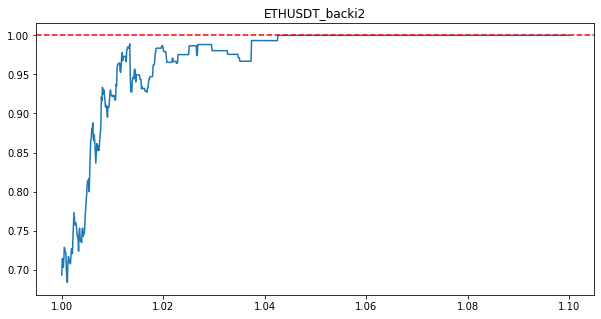

last_index : 18000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 26ms/step - loss: 0.3312 - mean_absolute_error: 0.3257 - val_loss: 0.0073 - val_mean_absolute_error: 0.0675

Epoch 00001: val_loss improved from inf to 0.00731, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_18000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0029 - val_mean_absolute_error: 0.0423

Epoch 00002: val_loss improved from 0.00731 to 0.00292, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_18000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0017 - mean_absolute_error: 0.0324 - val_loss: 0.0013 - val_mean_absolute

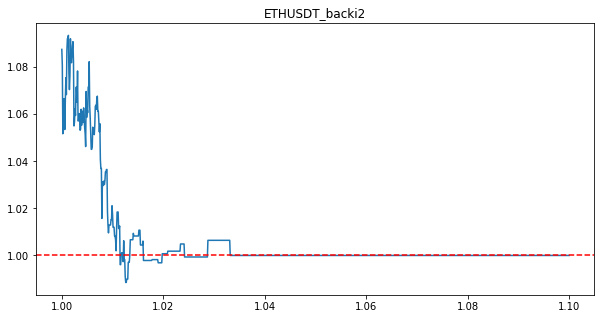

last_index : 19000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.2938 - mean_absolute_error: 0.3086 - val_loss: 0.0058 - val_mean_absolute_error: 0.0604

Epoch 00001: val_loss improved from inf to 0.00578, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_19000.h5
Epoch 2/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0024 - val_mean_absolute_error: 0.0383

Epoch 00002: val_loss improved from 0.00578 to 0.00241, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_19000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0016 - val_mean_absolute

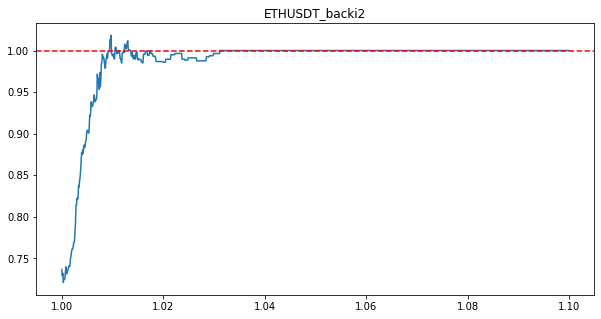

last_index : 20000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.3486 - mean_absolute_error: 0.3589 - val_loss: 0.0092 - val_mean_absolute_error: 0.0784

Epoch 00001: val_loss improved from inf to 0.00917, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_20000.h5
Epoch 2/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0023 - val_mean_absolute_error: 0.0373

Epoch 00002: val_loss improved from 0.00917 to 0.00231, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_20000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 0.0014 - val_mean_absolute

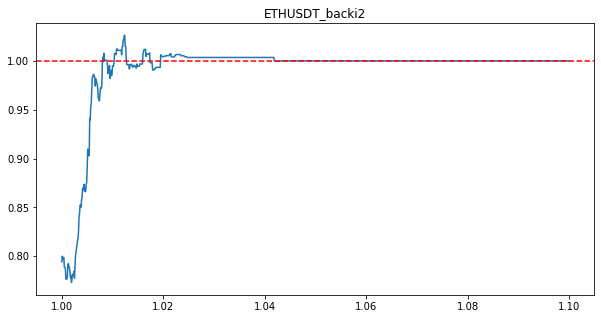

last_index : 21000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.4891 - mean_absolute_error: 0.3868 - val_loss: 0.0106 - val_mean_absolute_error: 0.0831

Epoch 00001: val_loss improved from inf to 0.01060, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_21000.h5
Epoch 2/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0069 - mean_absolute_error: 0.0655 - val_loss: 0.0047 - val_mean_absolute_error: 0.0530

Epoch 00002: val_loss improved from 0.01060 to 0.00466, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_21000.h5
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0032 - mean_absolute_error: 0.0440 - val_loss: 0.0026 - val_mean_absolute

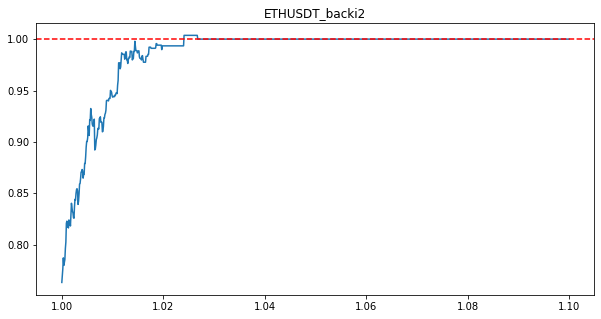

last_index : 22000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.3014 - mean_absolute_error: 0.3310 - val_loss: 0.0054 - val_mean_absolute_error: 0.0613

Epoch 00001: val_loss improved from inf to 0.00542, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_22000.h5
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.0029 - mean_absolute_error: 0.0415 - val_loss: 0.0019 - val_mean_absolute_error: 0.0340

Epoch 00002: val_loss improved from 0.00542 to 0.00190, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_22000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0014 - mean_absolute_error: 0.0293 - val_loss: 0.0011 - val_mean_absolute

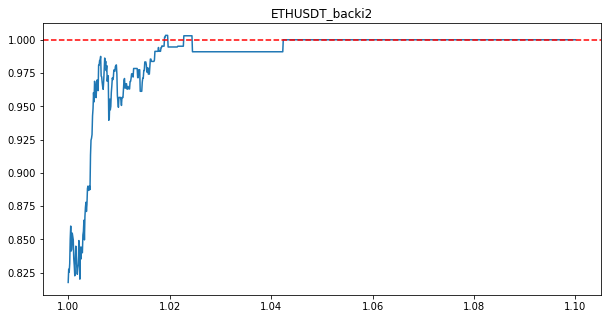

last_index : 23000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.2594 - mean_absolute_error: 0.2914 - val_loss: 0.0093 - val_mean_absolute_error: 0.0795

Epoch 00001: val_loss improved from inf to 0.00926, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_23000.h5
Epoch 2/100
55/55 [==============================] - 1s 26ms/step - loss: 0.0051 - mean_absolute_error: 0.0549 - val_loss: 0.0027 - val_mean_absolute_error: 0.0407

Epoch 00002: val_loss improved from 0.00926 to 0.00270, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_23000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0025 - mean_absolute_error: 0.0383 - val_loss: 0.0016 - val_mean_absolute

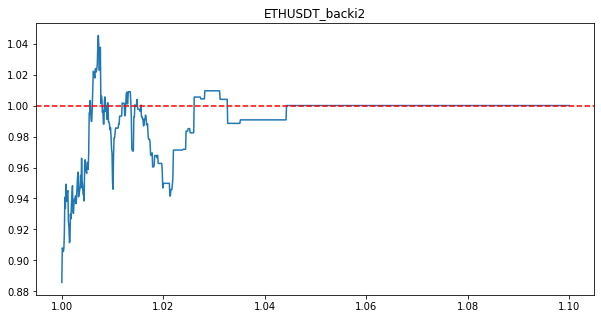

last_index : 24000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.1392 - mean_absolute_error: 0.2093 - val_loss: 0.0039 - val_mean_absolute_error: 0.0493

Epoch 00001: val_loss improved from inf to 0.00391, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_24000.h5
Epoch 2/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0029 - mean_absolute_error: 0.0416 - val_loss: 0.0014 - val_mean_absolute_error: 0.0285

Epoch 00002: val_loss improved from 0.00391 to 0.00139, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_24000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - val_loss: 7.7421e-04 - val_mean_abso

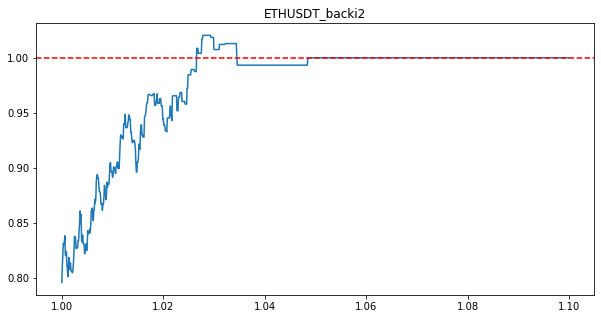

last_index : 25000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.0897 - mean_absolute_error: 0.1849 - val_loss: 0.0036 - val_mean_absolute_error: 0.0466

Epoch 00001: val_loss improved from inf to 0.00361, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_25000.h5
Epoch 2/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0027 - mean_absolute_error: 0.0403 - val_loss: 0.0019 - val_mean_absolute_error: 0.0337

Epoch 00002: val_loss improved from 0.00361 to 0.00186, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_25000.h5
Epoch 3/100
55/55 [==============================] - 1s 26ms/step - loss: 0.0013 - mean_absolute_error: 0.0286 - val_loss: 0.0012 - val_mean_absolute

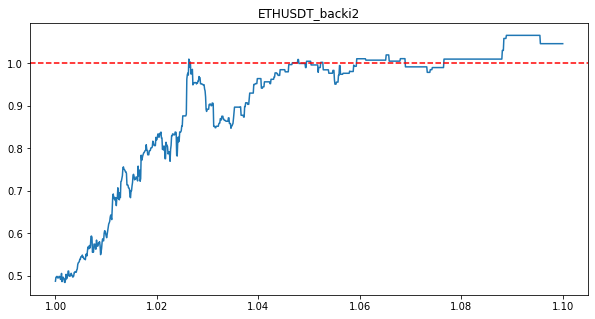

last_index : 26000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.2834 - mean_absolute_error: 0.2878 - val_loss: 0.0035 - val_mean_absolute_error: 0.0451

Epoch 00001: val_loss improved from inf to 0.00352, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_26000.h5
Epoch 2/100
55/55 [==============================] - 1s 26ms/step - loss: 0.0025 - mean_absolute_error: 0.0395 - val_loss: 0.0022 - val_mean_absolute_error: 0.0337

Epoch 00002: val_loss improved from 0.00352 to 0.00216, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_26000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0011 - mean_absolute_error: 0.0256 - val_loss: 0.0017 - val_mean_absolute

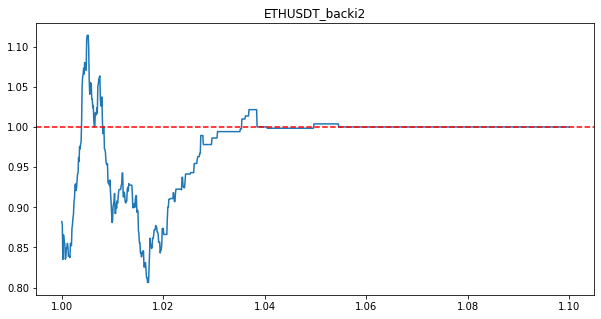

last_index : 27000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.0969 - mean_absolute_error: 0.1819 - val_loss: 0.0041 - val_mean_absolute_error: 0.0491

Epoch 00001: val_loss improved from inf to 0.00411, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_27000.h5
Epoch 2/100
55/55 [==============================] - 1s 25ms/step - loss: 0.0020 - mean_absolute_error: 0.0345 - val_loss: 0.0020 - val_mean_absolute_error: 0.0322

Epoch 00002: val_loss improved from 0.00411 to 0.00195, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_27000.h5
Epoch 3/100
55/55 [==============================] - 1s 25ms/step - loss: 9.3285e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0016 - val_mean_abso

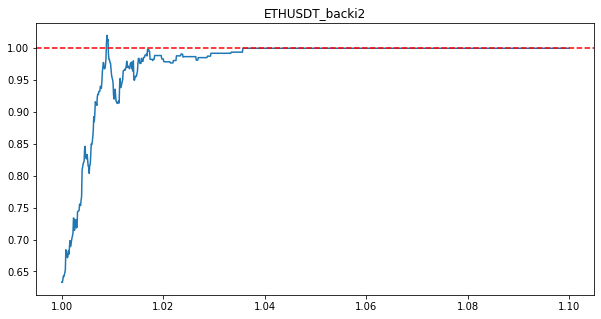

last_index : 28000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 33, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 2s 27ms/step - loss: 0.2735 - mean_absolute_error: 0.3158 - val_loss: 0.0077 - val_mean_absolute_error: 0.0701

Epoch 00001: val_loss improved from inf to 0.00770, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_28000.h5
Epoch 2/100
55/55 [==============================] - 1s 26ms/step - loss: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437

Epoch 00002: val_loss improved from 0.00770 to 0.00327, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_backi2_15_15_1000_28000.h5
Epoch 3/100
55/55 [==============================] - 1s 26ms/step - loss: 0.0022 - mean_absolute_error: 0.0355 - val_loss: 0.0018 - val_mean_absolute

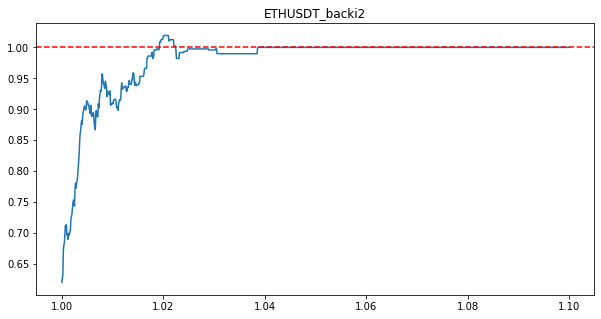

last_index : 29000


In [16]:
#         1. data slicing      #
tvt_size = 10000
shift_size = int(tvt_size * 0.1)
shift_i = 0

#         2. calc, iteration number     #
# data_len = len(data_x)


while 1:

  # if shift_i == 1:
  #   pass
  # else:
  #   shift_i += 1
  #   continue

  last_index = tvt_size + shift_size * shift_i
  print("last_index :", last_index)
  # print("last_index :", last_index)

  slice_x = data_x[shift_size * shift_i :last_index]
  
  #   reshape to 3d   #
  slice_x = slice_x.reshape(-1, slice_x.shape[1], slice_x.shape[2], 1)

  slice_labels = data_labels[shift_size * shift_i :last_index].reshape(-1, 1)

  if last_index > len(data_x):
    break

  else:
    shift_i += 1


  train_x = slice_x[:int(tvt_size * 0.7)]
  val_x = slice_x[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_x = slice_x[int(tvt_size * 0.9):]

  print("len(train_x) :", len(train_x))
  print("len(val_x) :", len(val_x))
  print("len(test_x) :", len(test_x))

  train_labels = slice_labels[:int(tvt_size * 0.7)]
  val_labels = slice_labels[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_labels = slice_labels[int(tvt_size * 0.9):]

  # sorted_pr = sorted(slice_labels, reverse=True)
  # pct = 0.28
  # len_pct = int(len(slice_labels) * pct)
  # pr_thresh = sorted_pr[len_pct]
  # print("pr_thresh :", pr_thresh)

  # pr_thresh = 1

  # train_y = np.where(train_labels > pr_thresh, 1, 0)
  # val_y = np.where(val_labels > pr_thresh, 1, 0)
  # test_y = np.where(test_labels > pr_thresh, 1, 0)

  train_y = train_labels
  val_y = val_labels
  test_y = test_labels
  
  from tensorflow.keras import utils

  # train_y_ohe = utils.to_categorical(train_y, 2)
  # val_y_ohe = utils.to_categorical(val_y, 2)
  # test_y_ohe = utils.to_categorical(test_y, 2)

  # train_y = train_labels[:, :, [target_label_index]]
  # val_y = val_labels[:, :, [target_label_index]]
  # test_y = test_labels[:, :, [target_label_index]]

  # print("train_labels.shape :", train_labels.shape)
  print("train_x.shape :", train_x.shape)
  print("train_y.shape :", train_y.shape)
  print()

  # from sklearn.utils import class_weight

  # label = train_y.reshape(-1, )
  # class_weights = class_weight.compute_class_weight('balanced', 
  #                                                     classes=np.unique(label),
  #                                                     y=label)
  # class_weights = dict(enumerate(class_weights))
  # print('class_weights :', class_weights)

  from tensorflow.keras.preprocessing.image import ImageDataGenerator 

  datagen = ImageDataGenerator( 
      # rotation_range = 45,
      # zoom_range = 0.5,
      # shear_range = 0.5,
      # horizontal_flip = True,
      # vertical_flip = True,
      # width_shift_range=0.5,
      # height_shift_range=0.5,
      # fill_mode = 'nearest'
      )

  valgen = ImageDataGenerator( 
      )

  datagen.fit(train_x)
  valgen.fit(val_x)
  batch_size = 128

  train_flow = datagen.flow(train_x, train_y, batch_size=batch_size) 
  val_flow = valgen.flow(val_x, val_y, batch_size=batch_size) 
  
  # train_flow = datagen.flow(train_x, train_y_ohe, batch_size=batch_size) 
  # val_flow = valgen.flow(val_x, val_y_ohe, batch_size=batch_size) 



  #         train         #
  pair_name = key.split(".")[0].split(" ")[1]

  # model_name = 'inner_tick_cnn_lscalemm_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, last_index)
  # model_name = 'inner_tick_cnn_lscalemm_postfee_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, last_index)
  # model_name = 'inner_tick_cnn_lscalemm_postfee_pct_%s_%s_%s_%s_%s.h5' % (pct* 1000, pair_name, input_size, label_size, last_index)
  model_name = 'inner_tick_cnnreg_lscalemm_prefee_gpu_%s_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, shift_size, last_index)
  # break

  #         train / test      #
  model = cnn2d_model(train_x.shape[1:])
  history = compile_and_fit(model, model_name, train_flow, val_flow)
  # history = compile_and_fit(model, model_name, train_flow, val_flow, class_weight=class_weights)
  
  # break
  model = tf.keras.models.load_model(ckpt_path + model_name)

  test_result = model.predict(test_x)
  print('test_result.shape :', test_result.shape)
  # print('pr_val.shape :', pr_val.shape)

  # y_score = test_result[:, [1]]
  y_score = test_result[:, [0]]
  print('test_y[:5] :', test_y.reshape(-1,)[:5])
  # print('np.unique(test_y) :', np.unique(test_y, return_counts=True))
  print('y_score[:5] :', y_score[:5])
  # print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

  print('test_y.shape :', test_y.shape)
  print('y_score.shape :', y_score.shape)

  print('len(test_y) :', len(test_y))

  from sklearn.metrics import precision_recall_curve

  #     precision recall curve   #
  # precision, recall, threshold = precision_recall_curve(test_y, y_score)
  # precision, recall = precision[:-1], recall[:-1]

  # plt.plot(threshold, precision, label='precision')
  # plt.plot(threshold, recall, label='recall')
  # plt.legend()
  # plt.title('precision recall')
  # plt.show()
  # print(y_pred)


  lvrg = 1
  fee = 0.0006


  # threshold = [0.65]
  # print('threshold :', threshold)
  # break

  acc_pr_bythr = []
  new_thresh = []

  threshold = np.arange(1, 1.1, 0.0001)

  for thresh in threshold:
    
    # if thresh < 0.5:
    #     continue

    y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
    # print('y_pred.shape :', y_pred.shape)
    # print('y_pred :', y_pred)

    #     compare precision     #

    # print('precision :', precision_score(test_y, y_pred))
    # print('recall :', recall_score(test_y, y_pred))
    # print()

    # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
    # print('np.isnan(np.sum(test_y)) :', np.isnan(np.sum(test_y)))

    # # plot_confusion_matrix(best_model, x_test, test_y, normalize=None)
    # # plt.show()  
    # print()

    # from sklearn.metrics import confusion_matrix

    # #     check win-ratio improvement     #
    # cmat = confusion_matrix(test_y, y_pred)
    # # print(cmat)
    # # print(np.sum(cmat, axis=1))
    

    # org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
    # ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
    # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

    test_size = len(test_y)
    test_pr_list = test_labels
    # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

    # print('pr_test.shape :', pr_test.shape)

    # print(y_pred)
    # print(test_pr_list)

    pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1)
    # print("pred_pr_list[:10] :", pred_pr_list[:10])

    #       after fee adjustment    #
    # pred_pr_list = (pred_pr_list - 1 - fee) * lvrg + 1

    # pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
    # pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
    # print('pred_pr_list.shape :', pred_pr_list.shape)

    # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    #   print('thresh :', thresh)
      
    # if len(threshold) == 1:
  #   plt.figure(figsize=(10, 5))
  #   plt.subplot(121)
  #   plt.plot(np.cumprod(test_pr_list))
  #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # # plt.show()

  #   plt.subplot(122)
  #   plt.plot(np.cumprod(pred_pr_list))
  #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
  #   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
  #   plt.show()


    acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
    new_thresh.append(thresh)


  print('acc_pr_bythr :', acc_pr_bythr)

  plt.figure(figsize=(10, 5))
  # plt.subplot(121)
  # plt.plot(threshold, precision, label='precision')
  # plt.plot(threshold, recall, label='recall')
  # plt.legend()
  # plt.title('precision recall')
  # plt.show()

  # plt.subplot(122)
  plt.plot(new_thresh, acc_pr_bythr)
  plt.axhline(1, linestyle='--', color='r')
  plt.title(pair_name)
  plt.show()



#### get_best_thr function

In [ ]:
def get_best_thr(thresh_list, test_x, pred_y, lvrg=5, plotting=False, pr_plot=False):
  
  thresh_pr_list = []
  fee = 0.0006

   
  # # plotting = True
  # plotting = False

  # # pr_plot = True
  # pr_plot = False

  #       find best thresh        #
  for thresh in tqdm(thresh_list):

    pr_list = []
    i = 0
    while 1:
    # for i in range(len(test_y)):

      try:
        input = test_x[i, :, target_label_index]
      except:
        input = test_x[i, :, 0]


      label = test_y[i]
      pred = pred_y[i]

      # print("label.shape :", label.shape)
      # print("len(label) :", len(label))
      # print("shift_size :", shift_size)
      # break

      # input_close = test_slice_close_x[i, :, :]
      # # input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
      # close = test_slice_label_close_x[i, :, :]

      #     find highest / lowest arg     #
      # high_arg = np.argmax(pred)
      # low_arg = np.argmin(pred)

      #     we always sell high, buy low    #
      label_pr = label[-1]
      pred_pr = pred[-1]

      if plotting:

        # if pred_pr > thresh:

          # plt.subplot(211)
          # plt.plot(np.arange(len(input_close)), input_close)
          # plt.plot(np.arange(len(close)) + input_size, close)
          # plt.axvline(high_arg + input_size)
          # plt.axvline(low_arg + input_size)

          # plt.subplot(212)
          # plt.plot(np.arange(len(input)), input,
          #         label='Inputs', marker='.', zorder=-10)    
          # plt.scatter(np.arange(len(label)), label,
          #           edgecolors='k', label='Labels', c='#2ca02c', s=64)
          # plt.scatter(np.arange(len(pred)), pred,
          #             marker='X', edgecolors='k', label='Predictions',
          #             c='#ff7f0e', s=64)

          plt.plot(label)
          plt.plot(pred)
          
          plt.axhline(thresh)
          # plt.plot(pred)
          # plt.plot(label)
          # plt.axvline(high_arg + input_size)
          # plt.axvline(low_arg + input_size)


          # plt.suptitle("%.3f" % pr)
          plt.show()

      calc_label_pr = (label_pr - fee) * lvrg + 1
      calc_pred_pr = (pred_pr - fee) * lvrg + 1

      if calc_pred_pr > thresh + 1:
        pr_list.append(calc_label_pr)
        # print("label_pr :", label_pr)

      #     i should moved to end of trading index    #
      #     long    #
      # if high_arg > low_arg:
      #   i += high_arg
      # else:
      #   i += low_arg

      i += 1

      # print("i :", i)

      if i >= len(test_y):
        break
      # else:
      #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

      #     shift, if trade complished    #

    if pr_plot:
      np_pr_list = np.array(pr_list)
      wr = len(np_pr_list[np_pr_list > 1]) / len(np_pr_list[np_pr_list != 1]) 

      plt.plot(np.cumprod(pr_list))
      plt.title("%s\nwr : %.3f" % (key, wr))
      plt.show()

    if len(pr_list) == 0:
      thresh_pr_list.append(1)
    else:
      thresh_pr_list.append(np.cumprod(pr_list)[-1])

  best_thr = thresh_list[np.argmax(thresh_pr_list)]

  if len(thresh_list) != 1:
    plt.plot(thresh_list, thresh_pr_list)
    plt.axvline(best_thr)
    plt.title(best_thr)
    plt.show()

  return best_thr

#### find best_thr

Text(0.5, 1.0, '0.013460000000000034')

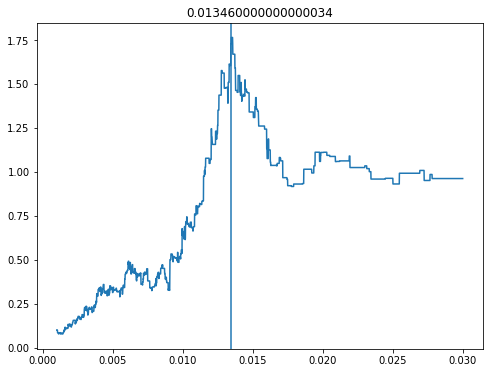

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
test_result = model.predict(test_x)

pred_y = test_result
# pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
# lvrg = 1
thresh_pr_list = []

# plotting = True
plotting = False

# pr_plot = True
pr_plot = False

thresh = 0.015
# thresh = -0.001

thresh_list = np.arange(0.001, 0.03, 1e-5)


#       find best thresh        #
for thresh in tqdm(thresh_list):

  pr_list = []
  i = 0
  while 1:
  # for i in range(len(test_y)):

    try:
      input = test_x[i, :, target_label_index]
    except:
      input = test_x[i, :, 0]


    label = test_y[i]
    pred = pred_y[i]

    # print("label.shape :", label.shape)
    # print("len(label) :", len(label))
    # print("shift_size :", shift_size)
    # break

    # input_close = test_slice_close_x[i, :, :]
    # # input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
    # close = test_slice_label_close_x[i, :, :]

    #     find highest / lowest arg     #
    # high_arg = np.argmax(pred)
    # low_arg = np.argmin(pred)

    #     we always sell high, buy low    #
    label_pr = label[-1]
    pred_pr = pred[-1]

    if plotting:

      # if pred_pr > thresh:

        # plt.subplot(211)
        # plt.plot(np.arange(len(input_close)), input_close)
        # plt.plot(np.arange(len(close)) + input_size, close)
        # plt.axvline(high_arg + input_size)
        # plt.axvline(low_arg + input_size)

        # plt.subplot(212)
        # plt.plot(np.arange(len(input)), input,
        #         label='Inputs', marker='.', zorder=-10)    
        # plt.scatter(np.arange(len(label)), label,
        #           edgecolors='k', label='Labels', c='#2ca02c', s=64)
        # plt.scatter(np.arange(len(pred)), pred,
        #             marker='X', edgecolors='k', label='Predictions',
        #             c='#ff7f0e', s=64)

        plt.plot(label)
        plt.plot(pred)
        
        plt.axhline(thresh)
        # plt.plot(pred)
        # plt.plot(label)
        # plt.axvline(high_arg + input_size)
        # plt.axvline(low_arg + input_size)


        # plt.suptitle("%.3f" % pr)
        plt.show()

    calc_label_pr = (label_pr - fee) * lvrg + 1
    calc_pred_pr = (pred_pr - fee) * lvrg + 1

    if calc_pred_pr > thresh + 1:
      pr_list.append(calc_label_pr)
      # print("label_pr :", label_pr)

    #     i should moved to end of trading index    #
    #     long    #
    # if high_arg > low_arg:
    #   i += high_arg
    # else:
    #   i += low_arg

    i += 1

    # print("i :", i)

    if i >= len(test_y):
      break
    # else:
    #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

    #     shift, if trade complished    #

  if pr_plot:
    np_pr_list = np.array(pr_list)
    wr = len(np_pr_list[np_pr_list > 1]) / len(np_pr_list[np_pr_list != 1]) 

    plt.plot(np.cumprod(pr_list))
    plt.title("%s\nwr : %.3f" % (key, wr))
    plt.show()

  thresh_pr_list.append(np.cumprod(pr_list)[-1])

best_thr = thresh_list[np.argmax(thresh_pr_list)]
plt.plot(thresh_list, thresh_pr_list)
plt.axvline(best_thr)
plt.title(best_thr)

#### val_thr on test_set

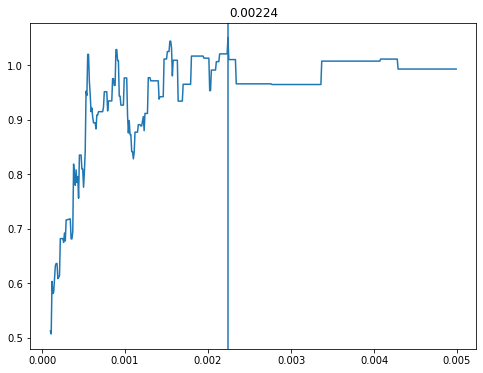

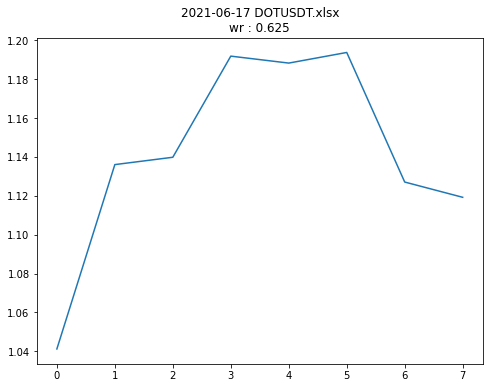

0.00224

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
val_result = model.predict(val_x)
test_result = model.predict(test_x)

# pred_y = test_result
# pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
# lvrg = 1
thresh_pr_list = []


# thresh = 0.015
# thresh = -0.001

thresh_list = np.arange(0.0001, 0.005, 1e-5)

val_best_thr = get_best_thr(thresh_list, val_x, val_result)

get_best_thr([val_best_thr], test_x, test_result, pr_plot=True)


#### train_thresh

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
train_result = model.predict(train_x)
train_best_thr = get_best_thr(thresh_list, train_x, train_result)
